<a href="https://colab.research.google.com/github/vsolodkyi/NeuralNetworks_SkillBox/blob/main/module_11/%D0%94%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D0%B5%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_%D0%BF%D0%BE_%D0%BF%D0%B5%D1%80%D0%B5%D0%BD%D0%BE%D1%81%D1%83_%D1%81%D1%82%D0%B8%D0%BB%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Style transfer

В этом задании вы реализуете алгоритм переноса стиля. По сути, вам нужно просто объеденить тетрадки из прошлых двух уроков в одну.

In [1]:
import tensorflow as tf
import IPython.display as display
import time
from tqdm import tqdm_notebook as tqdm

#tf.enable_eager_execution()

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import time
from pathlib import  Path

In [3]:
#@title (вспомогательный код -- выполните клетку)

def clip_0_1(image):
    """
    Мы хотим уметь отображать нашу полученную картинку, а для этого ее значения должны 
    находится в промежутке от 0 до 1. Наш алгоритм оптимизации этого нигде не учитывает
    поэтому к полученному изображению мы будем применять "обрезку" по значению
    
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def load_img(path_to_img, max_dim=512):
    """
    Данная функция считывает изображение с диска и приводит его к такому размеру,
    чтобы бОльшая сторона была равна max_dim пикселей.

    Для считывания изображения воспользуемся функциями tensorflow.
    """
    img = tf.io.read_file(path_to_img) # считываени файла
    img = tf.image.decode_image(img, channels=3)  # декодинг
    img = tf.image.convert_image_dtype(img, tf.float32) # uint8 -> float32, 255 -> 1
    
    shape = img.numpy().shape[:-1]
    long_dim = max(shape)
    scale = max_dim / long_dim
    new_shape = tuple((np.array(shape) * scale).astype(np.int32))

    img = tf.image.resize(img, new_shape) # изменение размера
    img = img[tf.newaxis, :] # добавляем batch dimension
    return img

def imshow(image, title=None):
    """
    Функция для отрисовки изображения
    """
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    plt.axis('off')
    plt.imshow(image)
    if title:
        plt.title(title)

def show_pair(original, generated, title=None):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    imshow(original, 'Original Image')
    plt.subplot(1, 2, 2)
    imshow(generated, title)

In [4]:
def get_vgg_layers_model(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

def gram_matrix(input_tensor):
    """
    В вычислении грам матрицы есть небольшие изменения по сравнению с прошлым уроком
    В этот раз мы делим не на W*H, а на W*H*C. 
    Принципиально это ничего не меняет. Это один из способов по разному взвесить 
    вклад разных слоев.
    Такое вычисление используется, например, здесь: https://arxiv.org/pdf/1603.08155.pdf
    """
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    
    num_locations = tf.cast(input_shape[1]*input_shape[2]*input_shape[3], tf.float32)
    return result/(num_locations)

## Задание 1. Определение экстрактора признаков.

Реализуйте класс `StyleAndContentExtractor`, который принимает на вход имена слоев, которые мы хотим извлекать из картинки для стилевого лосса (`style_layers`) и для контентного (`content_layers`).

Метод `__call__(self, inputs)` должен принимать на вход картинку, а возвращать словарь: 
```
{
    "style" {"имя слоя": матрица грама выхода этого слоя для картинки inputs, ...},
    "content" {"имя слоя": активации этого слоя для картинки inputs}
 }

```

In [5]:
class StyleAndContentExtractor:
    def __init__(self, style_layers, content_layers): 
        """
        style_layers -- список имен слоев для стиля
        content_layers -- список имен слоев для контента
        """
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.vgg_outputs_model = None
        # < YOUR CODE STARTS HERE >
        # self.vgg_outputs_model должна содержать модель, которая на вход 
        # принимает картинку а выдает выходы style_layers и content_layers.
        # Вам пригодится функция get_vgg_layers_model
        # Обязательно 'заморозьте' модель! 
        #self.vgg_outputs_model = get_vgg_layers_model([self.style_layers + self.content_layers])
        self.num_style_layers = len(style_layers)
        self.vgg_outputs_model = get_vgg_layers_model(style_layers + content_layers)
        #self.vgg_outputs_model  = get_vgg_layers_model(self.content_layers)[self.vgg_outputs_model]
        #[self.vgg_outputs_model.get_layer(name).output for name in self.content_layers]
        #self.vgg_outputs_model = style_outputs + content_outputs
        #self.vgg_outputs_model = style_outputs + content_outputs
        self.vgg_outputs_model.trainable = False
        



        
        # < YOUR CODE ENDS HERE >

        assert self.vgg_outputs_model.trainable == False, "Модель должна быть 'заморожена'."
        assert len(self.vgg_outputs_model.outputs) == len(style_layers) + len(content_layers), \
        f"Количество выходов vgg_outputs_model должно быть равно сумме количества слоев стиля и контента."\
        f"{len(self.vgg_outputs_model.outputs)}!= {len(style_layers) + len(content_layers)}"

    def __call__(self, inputs):
        """
        На входе 4х мерный тензор (картинка). Значения пикселей ограничены 0..1!
        
        На выходе: {
            "style" : {
                        "имя слоя1": матрица грама выхода этого слоя для картинки inputs,
                        "имя слоя2": ...,
                        "имя слоя3": ...
                        },
            "content" {
                        "имя слоя1": активации этого слоя для картинки inputs
                        "имя слоя2": ...,
                        "имя слоя3": ...
                      }
                    }

        """
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs*255.) # VGG препроцессинг
        outputs = self.vgg_outputs_model(preprocessed_input)
        features_dict = {}
        
        # < YOUR CODE STARTS HERE >
        # Заполните features_dict в соответствии с описанием выше.
        # Не забудьте применить функцию gram_matrix для выходов слоев стиля 
        style_outputs, content_outputs = outputs[:self.num_style_layers], outputs[self.num_style_layers:]
        style_outputs = [gram_matrix(style_output)  for style_output in style_outputs]
        features_dict["style"] = {name:value for name, value in zip(self.style_layers, style_outputs)}

        #features_dict["style"] = [gram_matrix(self.vgg_outputs_model.get_layer(style_layer).output) for style_layer in self.style_layers]  
        content_outputs = [content_output for content_output in content_outputs]    
        features_dict["content"] = {name:value for name, value in zip(self.content_layers, content_outputs)}  
        # < YOUR CODE ENDS HERE >
    
        return features_dict

In [6]:
# выберем эти слои для сравнения матриц
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']
content_layers = ['block4_conv2'] 

extractor = StyleAndContentExtractor(style_layers=style_layers, content_layers=content_layers)
sample_image = np.ones((1, 512, 512, 3), dtype=np.float32)
style_and_content_targets = extractor(tf.constant(sample_image))

80150528/80134624 [==============================] - 1s 0us/step


In [7]:
assert sorted(list(style_and_content_targets.keys())) == ["content", "style"], "StyleAndContentExtractor должен возвращать\
словарь с ключами 'style' и 'content'"

assert list(style_and_content_targets["style"]) == style_layers , \
f"Выбраны неправильные слои для стиля. {style_and_content_targets['style'].keys()}, а должны быть {style_layers}"
assert list(style_and_content_targets["content"]) == content_layers , \
f"Выбраны неправильные слои для контента. {style_and_content_targets['content'].keys()}, а должны быть {content_layers}"
print("Размеры выходов, отвечающих за стиль: ")
for k, v in style_and_content_targets['style'].items():
    shape = v.numpy().shape
    assert len(shape) == 3 and shape[1] == shape[2], f"Вероятно вы забыли посчитать матрицу Грама. \
    Размер выхода для стилевых слоев должен быть квадратным и с тремя размерностямя (1, W, W). Полученный {shape}"
    print(f"-- {k}:{v.numpy().shape}")
print("Размеры выходов, отвечающих за контент: ")
for k, v in style_and_content_targets['content'].items():
    print(f"-- {k}:{v.numpy().shape}")

print("-"*50, "\nSimple tests passed")

Размеры выходов, отвечающих за стиль: 
-- block1_conv1:(1, 64, 64)
-- block2_conv1:(1, 128, 128)
-- block3_conv1:(1, 256, 256)
-- block4_conv1:(1, 512, 512)
-- block5_conv1:(1, 512, 512)
Размеры выходов, отвечающих за контент: 
-- block4_conv2:(1, 64, 64, 512)
-------------------------------------------------- 
Simple tests passed


## Задание 2. Определение лосса.

Реализуйте функцию `style_content_loss(image, style_targets, content_targets)`.

Она принимает на вход текущую картинку, вычисляет для нее признаки с помощью `StyleAndContentExtractor`. Затем вычисляет MSE между его выходами (`features['style'], features['content']`) и `style_targets, content_targets` соответственно. 

Таким образом получается два лосса -- `style_loss` и `content_loss`, которые нужно сложить предварительно взвесив с весами, которые определены ниже, для получения style transfer лосса. 

Как и раньше к этому лоссу мы добавим total variation, чтобы на картинке было меньше шума. Его вес так же указан ниже.

In [8]:
style_weight = 100.0
content_weight = 5.0
tv_weight = 0.1

In [9]:
def style_content_loss(image, style_targets, content_targets): 
    """
    content_targets/style_targets -- {"имя_слоя": выход слоя/атрица грама, ...}

    1. Используйте extractor (глобальная переменная, не нужно определять в этой функции), 
    чтобы получить текущие признаки из картинки image
    2. Посчитайте MSE между слоями в style_targets и  соответствующими текущими стилевыми признаками
    и затем сложите их. Запишите это в переменную style_loss
    3. Сделайте аналогичные операции для content_targets и поместите результат в content_loss
    
    Вам может пригодится tf.keras.losses.MeanSquaredError(), tf.add_n(), 
    tf.image.total_variation(image)
    """
    style_loss = None
    content_loss = None

    # < YOUR CODE STARTS HERE >
    temp = extractor(image)
    current_style, current_content = temp['style'], temp['content'] 
    #current_style, current_content = extractor(image)['style'], extractor(image)['content']
    mse = mse = tf.keras.losses.MeanSquaredError(
          reduction=tf.keras.losses.Reduction.SUM)
    style_loss = tf.add_n(
      [mse(current_style[name], style_targets[name]) for name in current_style.keys()])
    
    #tf.keras.losses.MeanSquaredError(style_targets, current_targets['style'])
    content_loss = tf.add_n(
      [mse(current_content[name], content_targets[name]) for name in current_content.keys()])

    # < YOUR CODE ENDS HERE >
    
    loss = style_weight * style_loss + content_weight * content_loss + tv_weight * tf.image.total_variation(image)
    return loss

In [150]:
#temp = extractor(style_image)
#current_style, current_content = temp['style'], temp['content'] 
#style_content_loss(image, style_targets, content_targets)

In [10]:
#current_style['block1_conv1'] - style_targets['block1_conv1']

## Задание 3. Запустите оптимизацию и получите перенесенный стиль.

Выберите картинки стиля и контента и получите перенос стиля. Вы можете использовать предложенные комбинации или выбрать свои (так даже интереснее!). 

Предложенные параметры обучения и веса работают хорошо -- неплохой результат должен получиться без их изменения. Но эксперименты приветствуются. Размер картинки указан 1024. С таким размером оптимизация занимает около 15 минут.

Во вкладке Сolab -- Files (слева) вы увидите промежуточные результаты.

Для сдачи работы сохраните результаты выполнения в тетрадке (пример внизу).

In [11]:
def train_step(image, loss_func, optimizer):
    """
    Шаг оптимизации мы реализуем вручную (без .fit()). Такая реализация будет
    нам полезна в дальнейшем.

    """
    
    with tf.GradientTape() as tape: # "записываем" градиенты для дальнейшего использования
        loss = loss_func(image)
    grad = tape.gradient(loss, image) # dLoss/dImage
    optimizer.apply_gradients([(grad, image)]) # шаг градиентного спуск. в случае  GD: image = image - lambda*dLoss/dImage
                                         # картинка после этого шага изменилась!
    image.assign(clip_0_1(image)) # ~ image = clip_0_1(image), "обрезаем" неправильные значения
    return loss.numpy()

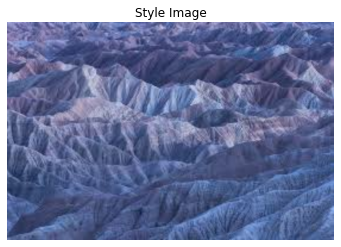

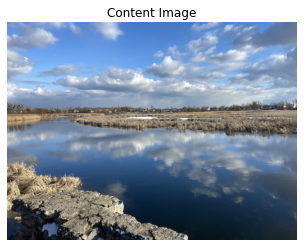

In [21]:
#content_path = tf.keras.utils.get_file('krem.jpg','https://media-cdn.tripadvisor.com/media/photo-s/16/44/b4/17/red-square-and-kremlin.jpg')
#style_path = tf.keras.utils.get_file('klimt.jpg','https://images.huffingtonpost.com/2012-11-28-2klimtderkuss1908.jpeg')
#content_path = tf.keras.utils.get_file('lala2.jpg','https://thoughtcatalog.files.wordpress.com/2017/02/screen-shot-2017-02-06-at-12-40-06-pm.png')
#style_path = tf.keras.utils.get_file('starry.jpg','https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1280px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg')

content_image = load_img('pol.jpg', 1024)
style_image = load_img('ice.jfif', 1024)

style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']
plt.figure()
imshow(style_image, "Style Image")
plt.figure()
imshow(content_image, "Content Image")

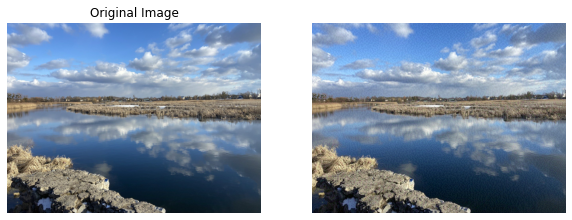

In [22]:

    
image = tf.Variable(content_image) # начинаем не с шума а с content_image!. Так оптимизация сходится быстрее.
# вы можете попробовать самостоятельно начинать оптимизацию со случайного прибижения. оптимизировать будет сложнее
# но результаты могут получиться интереснее. в таком случая рекомендуется начать с размера картики 512 а не 1024 как по 
# умолчанию. изменить это можно в клетке выше.
def loss(image):
    return style_content_loss(image, style_targets, content_targets)
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
# сделаем шаг оптимизации -- убедимся что все работает без ошибок.
train_step(image, loss_func=loss, optimizer=opt)
show_pair(content_image, image)

Total time: 959.4


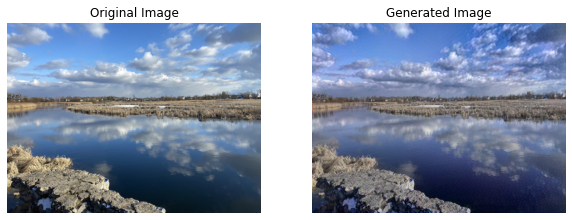

In [23]:
start = time.time()

content_name = Path('pol.jpg').stem
style_name = Path('ice.jfif').stem

epochs = 20
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in tqdm(range(steps_per_epoch)):
    step += 1
    train_step(image, loss_func=loss, optimizer=opt)

  display.clear_output(wait=True)
  show_pair(content_image, image, f"Generated Image.Train step: {step}")
  plt.imsave(f"{content_name}@{style_name}_{step}.png", image.numpy()[0])
  plt.show()

end = time.time()
display.clear_output(wait=True)
show_pair(content_image, image, f"Generated Image")
print("Total time: {:.1f}".format(end-start))

In [24]:
plt.imsave("result.png", image.numpy()[0])
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download("/content/result.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

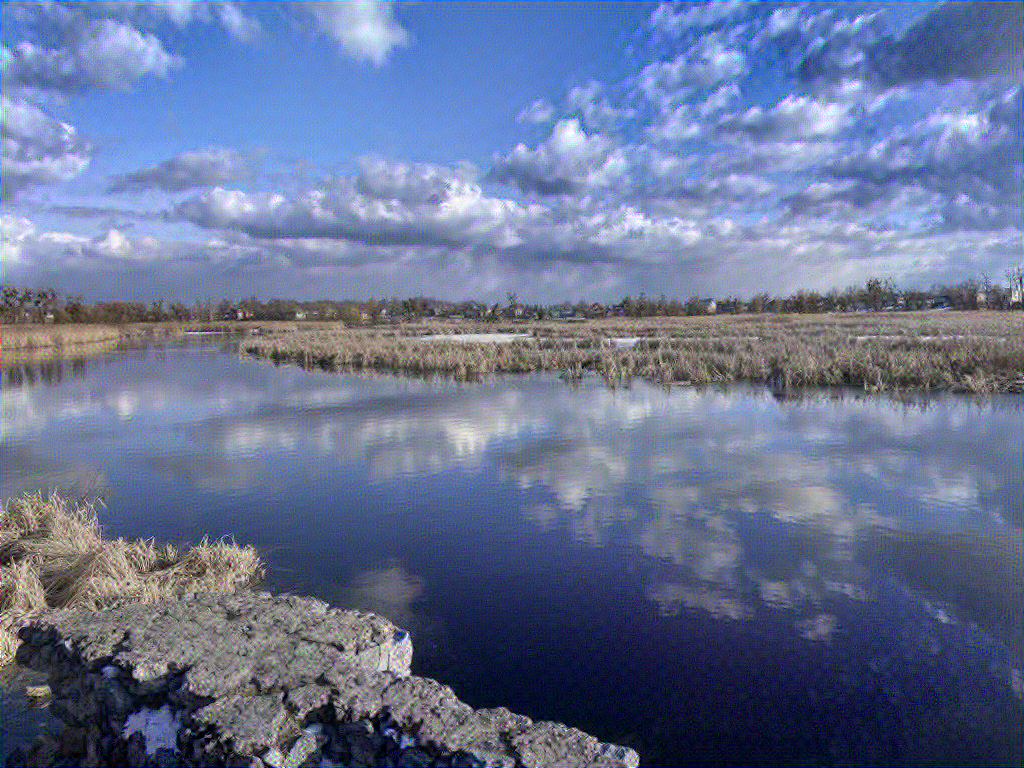

In [25]:
# вот что получилось у меня. для выполнения задания вы должны приложить аналогичным образом результат 
# для как минимум одной пары контент/стиль. вы можете использовать и больше комбинаций -- это затягивает :)
from IPython.display import Image
Image("/content/pol@ice_900.png")